# Imports

In [1]:
# Append location to path to allow custom modules to be used.
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))

In [2]:
import cgael
from cgael.models.SimpleColor import *

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layer

import pygad
import pygad.kerasga

import numpy as np
import pandas as pd

from PIL import Image

# Set Up

In [3]:
root_folder = os.path.join("C:",os.sep,"Users","nicho","PyProjects","CGAEL","results")
experiment_folder = "single_simple_color"
experiment_prefix = "ssc"

In [4]:
os.makedirs(os.path.join(root_folder, experiment_folder), exist_ok=True)

In [5]:
ID_FORMAT = "{experiment_prefix}_{i}"

i = 1
while os.path.exists(os.path.join(root_folder, experiment_folder, f"{ID_FORMAT.format(experiment_prefix=experiment_prefix, i=i)}.npy")):
    i += 1
    
experiment_id = ID_FORMAT.format(experiment_prefix=experiment_prefix, i=i)
filename = f"{experiment_id}.npy"
filepath = os.path.join(root_folder, experiment_folder, filename)
print(filepath)

C:\Users\nicho\PyProjects\CGAEL\results\single_simple_color\ssc_11.npy


# Training

In [6]:
ts = cgael.LanguageTokenSet("CHAT", '-')
gen = SimpleColorGenerator(
    [Swatch.WHITE, Swatch.BLACK, Swatch.RED, Swatch.GREEN, Swatch.BLUE, Swatch.YELLOW, Swatch.CYAN, Swatch.MAGENTA], 
    blur=0, batch_lock=True)
model = SimpleColorModel(token_set=ts, word_count=1, word_length=3)

In [7]:
ga_inst = model.train(
    generator = gen,
    generations = 100,
    num_solutions = 50,
    num_parents_mating = 5,
    mutation_percent_genes = .1,
)

c:\Users\nicho\PyProjects\CGAEL\.conda\Lib\site-packages\pygad\pygad.py:909: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")


Completed Generation: 1
Generating new batch...
Completed Generation: 2
Generating new batch...
Completed Generation: 3
Generating new batch...
Completed Generation: 4
Generating new batch...
Completed Generation: 5
Generating new batch...
Completed Generation: 6
Generating new batch...
Completed Generation: 7
Generating new batch...
Completed Generation: 8
Generating new batch...
Completed Generation: 9
Generating new batch...
Completed Generation: 10
Generating new batch...
Completed Generation: 11
Generating new batch...
Completed Generation: 12
Generating new batch...
Completed Generation: 13
Generating new batch...
Completed Generation: 14
Generating new batch...
Completed Generation: 15
Generating new batch...
Completed Generation: 16
Generating new batch...
Completed Generation: 17
Generating new batch...
Completed Generation: 18
Generating new batch...
Completed Generation: 19
Generating new batch...
Completed Generation: 20
Generating new batch...
Completed Generation: 21
Gene

In [8]:
np.save(filepath, np.array(model.model.get_weights(), dtype="object"))

# Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


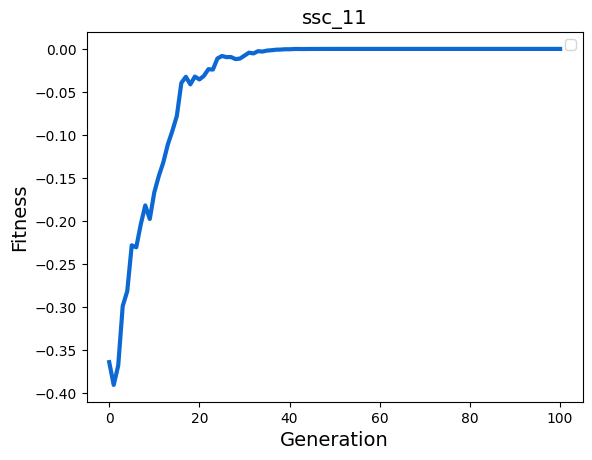

In [9]:
plot = ga_inst.plot_fitness(title=experiment_id, color="#0C69D3")
plot.savefig(os.path.join(root_folder, experiment_folder, f"{experiment_id}.png"))

In [10]:
KEY_SWATCH = "swatch"
KEY_TEXT = "text"
KEY_IN = "input"
KEY_OUT = "output"
KEY_ROUND = "output_rounded"

swatches = [Swatch.BLACK, Swatch.RED, Swatch.GREEN, Swatch.YELLOW, Swatch.BLUE, Swatch.MAGENTA, Swatch.CYAN, Swatch.WHITE]
samples = np.array([[sample_swatch(x)] for x in swatches])
lang, out = model.model(samples)
text = [ts.decode(x) for x in lang]

d = {x:[] for x in [KEY_SWATCH, KEY_TEXT, KEY_IN, KEY_OUT, KEY_ROUND]}
for s, t, i, o in zip(swatches, text, samples, out):
    d[KEY_SWATCH].append(s)
    d[KEY_TEXT].append(t)
    d[KEY_IN].append(i)
    o = o.numpy()
    d[KEY_OUT].append(o)
    o = np.round(o)
    d[KEY_ROUND].append(o)
df = pd.DataFrame(data=d)
display(df)

,swatch,text,input,output,output_rounded
0,Swatch.BLACK,HCA,"[[0.0, 0.0, 0.0]]","[[4.384646e-27, 2.8465224e-20, 6.6872837e-22]]","[[0.0, 0.0, 0.0]]"
1,Swatch.RED,HHA,"[[0.0, 0.0, 1.0]]","[[1.685863e-23, 3.1910468e-26, 1.0]]","[[0.0, 0.0, 1.0]]"
2,Swatch.GREEN,HCH,"[[0.0, 1.0, 0.0]]","[[1.864795e-20, 1.0, 7.292589e-22]]","[[0.0, 1.0, 0.0]]"
3,Swatch.YELLOW,HAC,"[[0.0, 1.0, 1.0]]","[[2.7029687e-22, 1.0, 1.0]]","[[0.0, 1.0, 1.0]]"
4,Swatch.BLUE,,"[[1.0, 0.0, 0.0]]","[[1.0, 6.4155204e-20, 2.36899e-25]]","[[1.0, 0.0, 0.0]]"
5,Swatch.MAGENTA,AHA,"[[1.0, 0.0, 1.0]]","[[1.0, 3.74171e-21, 1.0]]","[[1.0, 0.0, 1.0]]"
6,Swatch.CYAN,ACH,"[[1.0, 1.0, 0.0]]","[[1.0, 1.0, 6.795363e-23]]","[[1.0, 1.0, 0.0]]"
7,Swatch.WHITE,AHH,"[[1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0]]"


In [11]:
KEY_TEXT = "text"
KEY_OUT = "output"
KEY_ROUND = "output_rounded"

def generate_words(tokens, n):
    temp = tokens
    total = [''] + temp
    for _ in range(n-1):
        temp = [x+y for x in temp for y in tokens]
        total = total + temp
    return total

text = generate_words(ts.alphabet_tokens, 3)
data = np.array([ts.encode(x, shape=(1,3)) for x in text])
out = model.listener(data)

d = {x:[] for x in [KEY_TEXT, KEY_OUT, KEY_ROUND]}
for t, o in zip(text, out):
    d[KEY_TEXT].append(t)
    o = o.numpy()
    d[KEY_OUT].append(o)
    o = np.round(o)
    d[KEY_ROUND].append(o)
df = pd.DataFrame(data=d)
display(df)

,text,output,output_rounded
0,,"[[1.0, 6.4155204e-20, 2.36899e-25]]","[[1.0, 0.0, 0.0]]"
1,C,"[[6.6667135e-06, 1.4377983e-12, 6.721847e-19]]","[[0.0, 0.0, 0.0]]"
2,H,"[[3.5083232e-23, 1.6174942e-20, 6.3851853e-16]]","[[0.0, 0.0, 0.0]]"
3,A,"[[1.0, 1.8966243e-15, 5.949828e-17]]","[[1.0, 0.0, 0.0]]"
4,T,"[[0.99999994, 1.1523543e-16, 2.3441422e-18]]","[[1.0, 0.0, 0.0]]"
...,...,...,...
80,TAT,"[[1.0, 4.418185e-08, 0.0053889384]]","[[1.0, 0.0, 0.0]]"
81,TTC,"[[0.9999999, 1.0, 1.0]]","[[1.0, 1.0, 1.0]]"
82,TTH,"[[1.0, 1.0, 9.045384e-06]]","[[1.0, 1.0, 0.0]]"
83,TTA,"[[1.0, 5.245465e-15, 8.2946135e-06]]","[[1.0, 0.0, 0.0]]"
